# Importaciones de librerias y datos necesarios

In [1]:
import os
import numpy as np
import pandas as pd
import zipfile
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from sklearn.ensemble import RandomForestClassifier

## Importación opcional de los datos de la competencia en Kaggle

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = './kaggle-config'
!kaggle competitions download -c udea-ai4eng-20241

udea-ai4eng-20241.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extraer datos de los archivos de Kaggle

In [3]:
path = "udea-ai4eng-20241.zip"
directory = "data/"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(directory)

# Visualizar dataframe con los datos de la competencia

In [4]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df.head(5)

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo


In [5]:
df.dtypes

ID                                 int64
PERIODO                            int64
ESTU_PRGM_ACADEMICO               object
ESTU_PRGM_DEPARTAMENTO            object
ESTU_VALORMATRICULAUNIVERSIDAD    object
ESTU_HORASSEMANATRABAJA           object
FAMI_ESTRATOVIVIENDA              object
FAMI_TIENEINTERNET                object
FAMI_EDUCACIONPADRE               object
FAMI_TIENELAVADORA                object
FAMI_TIENEAUTOMOVIL               object
ESTU_PRIVADO_LIBERTAD             object
ESTU_PAGOMATRICULAPROPIO          object
FAMI_TIENECOMPUTADOR              object
FAMI_TIENEINTERNET.1              object
FAMI_EDUCACIONMADRE               object
RENDIMIENTO_GLOBAL                object
dtype: object

## Se visualizan los datos faltantes

In [6]:
def show_missing_values(df):
    plt.figure(figsize=(10,6))
    sns.displot(
        data=df.isna().melt(value_name="Faltantes"),
        y="variable",
        hue="Faltantes",
        multiple="fill",
        aspect=1.25
    )

<Figure size 1000x600 with 0 Axes>

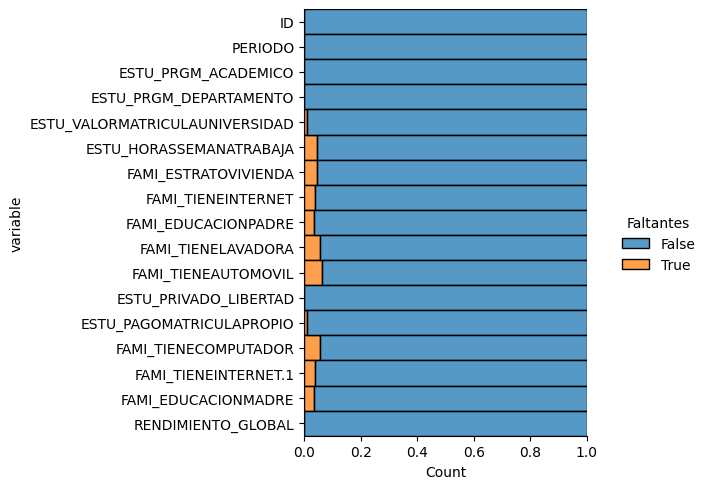

In [7]:
show_missing_values(df)

# Limpieza de los valores en la columna ESTU_PRGM_ACADEMICO 

In [8]:
def normalize_string(s):
    return (
        unicodedata.normalize('NFKD', s)
        .encode('ascii', errors='ignore')
        .decode('utf-8')
        .lower()
        .strip()
        .replace('  ', ' ')
    )

df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(normalize_string)
df_test['ESTU_PRGM_ACADEMICO'] = df_test['ESTU_PRGM_ACADEMICO'].apply(normalize_string)

In [9]:
df['ESTU_PRGM_ACADEMICO'].value_counts().to_dict()

{'administracion de empresas': 76679,
 'derecho': 53244,
 'contaduria publica': 51846,
 'psicologia': 49309,
 'ingenieria industrial': 34794,
 'ingenieria civil': 21315,
 'medicina': 18099,
 'ingenieria de sistemas': 18028,
 'licenciatura en pedagogia infantil': 14850,
 'ingenieria ambiental': 13130,
 'trabajo social': 12686,
 'enfermeria': 12186,
 'arquitectura': 11469,
 'administracion en salud ocupacional': 11018,
 'negocios internacionales': 8858,
 'economia': 7515,
 'ingenieria mecanica': 7271,
 'ingenieria electronica': 6804,
 'administracion financiera': 6412,
 'comunicacion social': 6351,
 'fisioterapia': 5992,
 'odontologia': 5272,
 'administracion publica territorial': 5002,
 'administracion de negocios internacionales': 4962,
 'ingenieria quimica': 4142,
 'diseno grafico': 3919,
 'comunicacion social- periodismo': 3512,
 'biologia': 3153,
 'ingenieria electrica': 3019,
 'medicina veterinaria y zootecnia': 2865,
 'ingenieria mecatronica': 2754,
 'diseno industrial': 2697,
 'm

In [10]:
def extraer_primera_palabra(texto):
    palabra = texto.replace('3','')
    palabra = palabra.split()[0]
    palabra= palabra.replace('-','')
    return palabra

df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)
df_test['ESTU_PRGM_ACADEMICO'] = df_test['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)

In [11]:
df['ESTU_PRGM_ACADEMICO'].value_counts()

ESTU_PRGM_ACADEMICO
ingenieria        147722
administracion    126816
licenciatura       66280
derecho            53696
contaduria         52298
                   ...  
narrativas             7
computacion            5
bellas                 4
ingeniieria            3
animacion              2
Name: count, Length: 134, dtype: int64

Conservar los 10 programas academicos más frecuentes

In [12]:
frecuencia = df['ESTU_PRGM_ACADEMICO'].value_counts()
top_10 = frecuencia.nlargest(10).index
df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: x if x in top_10 else 'otra')
df_test['ESTU_PRGM_ACADEMICO'] = df_test['ESTU_PRGM_ACADEMICO'].apply(lambda x: x if x in top_10 else 'otra')

In [13]:
df['ESTU_PRGM_ACADEMICO'].value_counts()

ESTU_PRGM_ACADEMICO
ingenieria        147722
otra              131220
administracion    126816
licenciatura       66280
derecho            53696
contaduria         52298
psicologia         49309
medicina           23508
comunicacion       16779
trabajo            12686
enfermeria         12186
Name: count, dtype: int64

# Limpieza de columnas duplicadas

## FAMI_TIENEINTERNET

Mediante ``` df.dtypes ``` verificamos que tenemos 2 columnas que inician con 'FAMI_TIENEINTERNET', vamos validar si tiene los mismos datos.

In [14]:
(df['FAMI_TIENEINTERNET'] == df['FAMI_TIENEINTERNET.1']).value_counts()

True     665871
False     26629
Name: count, dtype: int64

In [15]:
np.nan == np.nan

False

In [16]:
df['FAMI_TIENEINTERNET.1'].isna().sum()

26629

In [17]:
df['FAMI_TIENEINTERNET.1'].isna().sum() == df['FAMI_TIENEINTERNET'].isna().sum()

True

Tenemos **26629** que no coinciden en la comparacion entre 'FAMI_TIENEINTERNET' y 'FAMI_TIENEINTERNET.1'. Esto se debe a que al comparar los datos nulos de las columnas ocurre la condicion ```np.nan == np.nan``` y es igual a ```False```, ademas, la cantidad de datos nulos en ambas columnas es **26629**. Por tanto se puede eliminar la comuna 'FAMI_TIENEINTERNET.1'.

In [18]:
df.drop(['FAMI_TIENEINTERNET.1'], axis = 1, inplace = True) #columna repetida
df_test.drop(['FAMI_TIENEINTERNET.1'], axis = 1, inplace = True) #columna repetida

# Limpieza de filas con valores nulos


In [19]:
df.shape

(692500, 16)

In [20]:
df = df.dropna()
df

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
0,904256,20212,enfermeria,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Postgrado,medio-alto
1,645256,20212,derecho,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,Técnica o tecnológica incompleta,bajo
2,308367,20203,otra,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Secundaria (Bachillerato) completa,bajo
3,470353,20195,administracion,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Secundaria (Bachillerato) completa,alto
4,989032,20212,psicologia,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Primaria completa,medio-bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,20195,otra,LA GUAJIRA,Entre 500 mil y menos de 1 millón,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,Si,Si,Secundaria (Bachillerato) incompleta,medio-alto
692496,754213,20212,psicologia,NORTE SANTANDER,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Primaria incompleta,Si,No,N,No,Si,Secundaria (Bachillerato) incompleta,bajo
692497,504185,20183,administracion,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Menos de 10 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,Si,Si,Secundaria (Bachillerato) incompleta,medio-bajo
692498,986620,20195,psicologia,TOLIMA,Entre 2.5 millones y menos de 4 millones,Menos de 10 horas,Estrato 1,No,Primaria completa,No,No,N,Si,Si,Primaria completa,bajo


# Limpieza de variables categoricas con valores nulos

A continuación realizaremos la limpieza de las variables ESTU_VALORMATRICULAUNIVERSIDAD, ESTU_HORASSEMANATRABAJA, FAMI_ESTRATOVIVIENDA, FAMI_TIENEINTERNET, FAMI_EDUCACIONPADRE, FAMI_TIENELAVADORA, FAMI_TIENEAUTOMOVIL, ESTU_PRIVADO_LIBERTAD, ESTU_PAGOMATRICULAPROPIO, FAMI_TIENECOMPUTADOR y FAMI_EDUCACIONMADRE.

In [21]:
categorical_columns = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
                            'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL',
                            'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_EDUCACIONMADRE']

In [22]:
def show_unique_values_by_columns(df, array_columns):
    for col in array_columns:
        print(f'{col} =', df[col].unique(),'\n')

In [23]:
show_unique_values_by_columns(df, categorical_columns)

ESTU_VALORMATRICULAUNIVERSIDAD = ['Entre 5.5 millones y menos de 7 millones'
 'Entre 2.5 millones y menos de 4 millones'
 'Entre 4 millones y menos de 5.5 millones' 'Más de 7 millones'
 'Entre 1 millón y menos de 2.5 millones'
 'Entre 500 mil y menos de 1 millón' 'Menos de 500 mil'
 'No pagó matrícula'] 

ESTU_HORASSEMANATRABAJA = ['Menos de 10 horas' '0' 'Más de 30 horas' 'Entre 21 y 30 horas'
 'Entre 11 y 20 horas'] 

FAMI_ESTRATOVIVIENDA = ['Estrato 3' 'Estrato 4' 'Estrato 5' 'Estrato 2' 'Estrato 1' 'Estrato 6'
 'Sin Estrato'] 

FAMI_TIENEINTERNET = ['Si' 'No'] 

FAMI_EDUCACIONPADRE = ['Técnica o tecnológica incompleta' 'Técnica o tecnológica completa'
 'Secundaria (Bachillerato) completa' 'No sabe' 'Primaria completa'
 'Educación profesional completa' 'Educación profesional incompleta'
 'Primaria incompleta' 'Postgrado' 'Secundaria (Bachillerato) incompleta'
 'Ninguno' 'No Aplica'] 

FAMI_TIENELAVADORA = ['Si' 'No'] 

FAMI_TIENEAUTOMOVIL = ['Si' 'No'] 

ESTU_PAGOMATRICULAPROPIO = [

Método para llenar nulos con la moda de una columna

In [24]:
def fillna_with_mode(df, array_columns):
  for col in array_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

Método para llenar nulos con el valor de un atributo de una columna

In [25]:
def fillna_with_a_value(df, col, value):
    df[col] = df[col].fillna(value)

Método para remplazar un valor con un nuevo valor de una columna

In [26]:
def replace_value_in_a_column(df, col, to_replace, new_value):
    df[col] = df[col].replace(to_replace, new_value)

In [27]:
categorical_columns1 = categorical_columns.copy()
categorical_columns1.remove('FAMI_EDUCACIONPADRE')
categorical_columns1.remove('FAMI_EDUCACIONMADRE')

In [28]:

fillna_with_mode(df_test, categorical_columns1)

In [29]:
categorical_columns2 = ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']

In [30]:
for col in categorical_columns2:
    fillna_with_a_value(df_test, col, 'No sabe')

In [31]:
for col in categorical_columns2:
    replace_value_in_a_column(df_test, col, 'No Aplica', 'Ninguno')

Verificar que no tengamos datos nulos

<Figure size 1000x600 with 0 Axes>

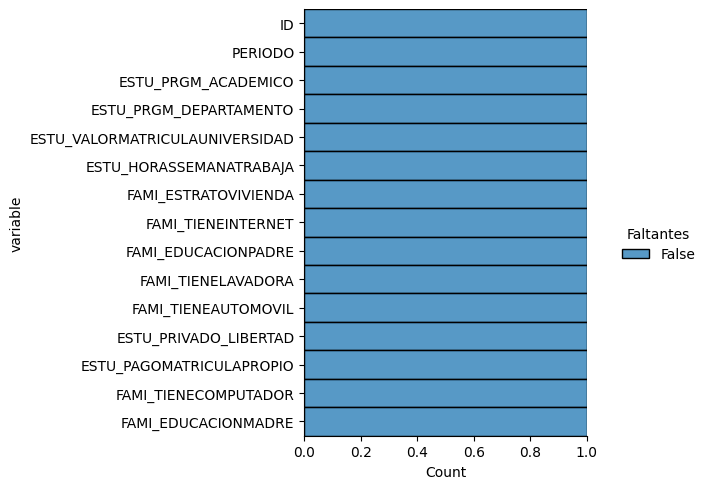

In [32]:
show_missing_values(df_test)

# Columna periodo de int a object

In [33]:
df['PERIODO'].unique()

array([20212, 20203, 20195, 20183, 20184, 20196], dtype=int64)

In [34]:
str_period = df['PERIODO'].astype(str)
df['PERIODO'] = str_period.str[:4] + '_' + str_period.str[4]

Estandarizamos la columna periodo añladiendo un "_" y como objeto y cambiarlo de int a obj

In [35]:
str_period_test = df_test['PERIODO'].astype(str)
df_test['PERIODO'] = str_period_test.str[:4] + '_' + str_period_test.str[4]

In [36]:
df.astype({'PERIODO': 'object'}).dtypes

ID                                 int64
PERIODO                           object
ESTU_PRGM_ACADEMICO               object
ESTU_PRGM_DEPARTAMENTO            object
ESTU_VALORMATRICULAUNIVERSIDAD    object
ESTU_HORASSEMANATRABAJA           object
FAMI_ESTRATOVIVIENDA              object
FAMI_TIENEINTERNET                object
FAMI_EDUCACIONPADRE               object
FAMI_TIENELAVADORA                object
FAMI_TIENEAUTOMOVIL               object
ESTU_PRIVADO_LIBERTAD             object
ESTU_PAGOMATRICULAPROPIO          object
FAMI_TIENECOMPUTADOR              object
FAMI_EDUCACIONMADRE               object
RENDIMIENTO_GLOBAL                object
dtype: object

# Mapear los valores de las columnas según las asignaciones proporcionadas

In [37]:

mapeo_valormatricula = {
    'No pagó matrícula': 1,
    'Menos de 500 mil': 2,
    'Entre 500 mil y menos de 1 millón': 3,
    'Entre 1 millón y menos de 2.5 millones': 4,
    'Entre 2.5 millones y menos de 4 millones': 5,
    'Entre 4 millones y menos de 5.5 millones': 6,
    'Entre 5.5 millones y menos de 7 millones': 7,
    'Más de 7 millones': 8
}

mapeo_horassemanatrabaja = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
}
mapeo_estratovivienda = {
    'Sin Estrato': 0,
    'Estrato 1': 1,
    'Estrato 2': 2,
    'Estrato 3': 3,
    'Estrato 4': 4,
    'Estrato 5': 5,
    'Estrato 6': 6
}

map_rendimiento_global = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}

df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapeo_valormatricula).astype('uint8')
df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].map(mapeo_horassemanatrabaja).astype('uint8')
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].map(mapeo_estratovivienda).astype('uint8')
df['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL'].map(map_rendimiento_global).astype('uint8')

df_test['ESTU_VALORMATRICULAUNIVERSIDAD'] = df_test['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapeo_valormatricula).astype('uint8')
df_test['ESTU_HORASSEMANATRABAJA'] = df_test['ESTU_HORASSEMANATRABAJA'].map(mapeo_horassemanatrabaja).astype('uint8')
df_test['FAMI_ESTRATOVIVIENDA'] = df_test['FAMI_ESTRATOVIVIENDA'].map(mapeo_estratovivienda).astype('uint8')

In [38]:
def set_integer_by_text(value, true_text):
  if value and value == true_text:
    return 1
  else: 
    return 0

Cambiar las variables de "Si" y "No" a 0 y 1

In [39]:
df['FAMI_TIENELAVADORA'] = df['FAMI_TIENELAVADORA'].map(lambda x: set_integer_by_text(x, 'Si'))
df['FAMI_TIENEAUTOMOVIL'] = df['FAMI_TIENEAUTOMOVIL'].map(lambda x: set_integer_by_text(x, 'Si'))
df['ESTU_PRIVADO_LIBERTAD'] = df['ESTU_PRIVADO_LIBERTAD'].map(lambda x: set_integer_by_text(x, 'S'))
df['ESTU_PAGOMATRICULAPROPIO'] = df['ESTU_PAGOMATRICULAPROPIO'].map(lambda x: set_integer_by_text(x, 'Si'))
df['FAMI_TIENECOMPUTADOR'] = df['FAMI_TIENECOMPUTADOR'].map(lambda x: set_integer_by_text(x, 'Si'))
df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].map(lambda x: set_integer_by_text(x, 'Si'))

In [40]:
df_test['FAMI_TIENELAVADORA'] = df_test['FAMI_TIENELAVADORA'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['FAMI_TIENEAUTOMOVIL'] = df_test['FAMI_TIENEAUTOMOVIL'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['ESTU_PRIVADO_LIBERTAD'] = df_test['ESTU_PRIVADO_LIBERTAD'].map(lambda x: set_integer_by_text(x, 'S'))
df_test['ESTU_PAGOMATRICULAPROPIO'] = df_test['ESTU_PAGOMATRICULAPROPIO'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['FAMI_TIENECOMPUTADOR'] = df_test['FAMI_TIENECOMPUTADOR'].map(lambda x: set_integer_by_text(x, 'Si'))
df_test['FAMI_TIENEINTERNET'] = df_test['FAMI_TIENEINTERNET'].map(lambda x: set_integer_by_text(x, 'Si'))

In [41]:
df

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL
0,904256,2021_2,enfermeria,BOGOTÁ,7,1,3,1,Técnica o tecnológica incompleta,1,1,0,0,1,Postgrado,2
1,645256,2021_2,derecho,ATLANTICO,5,0,3,0,Técnica o tecnológica completa,1,0,0,0,1,Técnica o tecnológica incompleta,0
2,308367,2020_3,otra,BOGOTÁ,5,4,3,1,Secundaria (Bachillerato) completa,1,0,0,0,0,Secundaria (Bachillerato) completa,0
3,470353,2019_5,administracion,SANTANDER,6,0,4,1,No sabe,1,0,0,0,1,Secundaria (Bachillerato) completa,3
4,989032,2021_2,psicologia,ANTIOQUIA,5,3,3,1,Primaria completa,1,1,0,0,1,Primaria completa,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,2019_5,otra,LA GUAJIRA,3,2,2,1,Secundaria (Bachillerato) completa,1,0,0,1,1,Secundaria (Bachillerato) incompleta,2
692496,754213,2021_2,psicologia,NORTE SANTANDER,5,4,3,1,Primaria incompleta,1,0,0,0,1,Secundaria (Bachillerato) incompleta,0
692497,504185,2018_3,administracion,BOGOTÁ,4,1,3,1,Secundaria (Bachillerato) completa,1,0,0,1,1,Secundaria (Bachillerato) incompleta,1
692498,986620,2019_5,psicologia,TOLIMA,5,1,1,0,Primaria completa,0,0,0,1,1,Primaria completa,0


Get dummies para las variables categoricas restantes

In [42]:
categorical_columns = ['PERIODO','ESTU_PRGM_ACADEMICO','ESTU_PRGM_DEPARTAMENTO','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE']
df = pd.get_dummies(df, columns=categorical_columns, dummy_na=False, dtype='uint8')
df_test = pd.get_dummies(df_test, columns=categorical_columns, dummy_na=False, dtype='uint8')

In [43]:
df

,ID,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,...,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No Aplica,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
0,904256,7,1,3,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,645256,5,0,3,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,308367,5,4,3,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,470353,6,0,4,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,989032,5,3,3,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,3,2,2,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
692496,754213,5,4,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
692497,504185,4,1,3,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
692498,986620,5,1,1,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [44]:
df_test

,ID,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,...,FAMI_EDUCACIONMADRE_Educación profesional incompleta,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
0,550236,2,1,3,1,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,98545,5,3,2,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,499179,4,0,3,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,782980,4,3,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,785185,5,2,2,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,5,4,1,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
296782,209415,4,0,4,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
296783,239074,5,4,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
296784,963852,7,2,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Organizar los datos para entrenamiento y prueba

In [46]:
df_test1 = df_test.drop("ID", axis=1)
X = df.drop(columns=['RENDIMIENTO_GLOBAL','ID'])
y = df['RENDIMIENTO_GLOBAL']
y

0         2
1         0
2         0
3         3
4         1
         ..
692495    2
692496    0
692497    1
692498    0
692499    3
Name: RENDIMIENTO_GLOBAL, Length: 628896, dtype: uint8

In [47]:
X

,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,PERIODO_2018_3,...,FAMI_EDUCACIONMADRE_Ninguno,FAMI_EDUCACIONMADRE_No Aplica,FAMI_EDUCACIONMADRE_No sabe,FAMI_EDUCACIONMADRE_Postgrado,FAMI_EDUCACIONMADRE_Primaria completa,FAMI_EDUCACIONMADRE_Primaria incompleta,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) completa,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta
0,7,1,3,1,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,5,0,3,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,5,4,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,6,0,4,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5,3,3,1,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,3,2,2,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
692496,5,4,3,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
692497,4,1,3,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
692498,5,1,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0


# Busqueda de los mejores parametros para Random Forest

Probamos diferente combinaciones de hiperparametros para ver cual nos da mejores resultados.

In [ ]:
from sklearn.model_selection import cross_validate, ShuffleSplit
data = []
for i in [16,17]:
    for j in range(6, 11, 1):
        test_size = 0.3
        val_size  = test_size/(1-test_size)
        estimator = RandomForestClassifier(n_estimators=i, max_depth=j)
        z = cross_validate(estimator, X, y, return_train_score=True,
                    return_estimator=True, cv=ShuffleSplit
                    (n_splits=10, test_size=val_size))
        data.append({
            "n_estimators": i,
            "min_samples_leaf": j,
            "test_score": np.mean(z["test_score"]),
            "train_score": np.mean(z["train_score"])})
table = pd.DataFrame(data)
table

,n_estimators,min_samples_leaf,test_score,train_score
0,16,6,0.382009,0.383888
1,16,7,0.387277,0.390058
2,16,8,0.391585,0.395477
3,16,9,0.393806,0.401449
4,16,10,0.397138,0.410141
5,17,6,0.382617,0.383895
6,17,7,0.388588,0.390391
7,17,8,0.390483,0.394819
8,17,9,0.393502,0.401603
9,17,10,0.397094,0.408853


In [ ]:
from sklearn.model_selection import cross_validate, ShuffleSplit
data = []
for i in [17]:
    for j in range(11, 14, 1):
        test_size = 0.3
        val_size  = test_size/(1-test_size)
        estimator = RandomForestClassifier(n_estimators=i, max_depth=j)
        z = cross_validate(estimator, X, y, return_train_score=True,
                    return_estimator=True, cv=ShuffleSplit
                    (n_splits=10, test_size=val_size))
        data.append({
            "n_estimators": i,
            "min_samples_leaf": j,
            "test_score": np.mean(z["test_score"]),
            "train_score": np.mean(z["train_score"])})
table = pd.DataFrame(data)
table

,n_estimators,min_samples_leaf,test_score,train_score
0,17,11,0.399473,0.418507
1,17,12,0.400570,0.429044
2,17,13,0.401280,0.441225


Con este preprocesado que es un poco diferente al del NB 06, elegimos la combinacion 17 estimadores con 13 hojas. A pesar de tener una diferencia de test y train mayor a la combinacion 16 estimadores y 10 hojas, con 17 est y 13 hoj tenemos un mayor acierto en test.

# Entrenamiento: RandomForestClassifier

In [48]:
rf = RandomForestClassifier(n_estimators=17, min_samples_leaf= 13)
rf.fit(X, y)

RandomForestClassifier(min_samples_leaf=13, n_estimators=17)

In [ ]:
y_pred = rf.predict(df_test1)
y_pred

array([2, 2, 3, ..., 2, 3, 3], dtype=uint8)

# Preparacion para enviar a Kaggle

In [ ]:
def rendimiento_global_num2text(nums):
    mapa = {
        0: 'bajo',
        1: 'medio-bajo',
        2: 'medio-alto',
        3: 'alto'
    }
    return [mapa.get(num) for num in nums]

In [ ]:
y_pred_kaggle = rendimiento_global_num2text(y_pred)
y_pred_kaggle

['medio-alto',
 'medio-alto',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'alto',
 'alto',
 'medio-bajo',
 'alto',
 'alto',
 'bajo',
 'alto',
 'alto',
 'alto',
 'bajo',
 'alto',
 'bajo',
 'medio-bajo',
 'medio-alto',
 'alto',
 'alto',
 'medio-alto',
 'bajo',
 'medio-alto',
 'medio-bajo',
 'medio-alto',
 'bajo',
 'bajo',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'alto',
 'alto',
 'bajo',
 'alto',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'medio-alto',
 'medio-alto',
 'medio-bajo',
 'bajo',
 'bajo',
 'medio-bajo',
 'medio-alto',
 'bajo',
 'medio-alto',
 'medio-bajo',
 'alto',
 'alto',
 'bajo',
 'alto',
 'medio-alto',
 'bajo',
 'bajo',
 'alto',
 'bajo',
 'alto',
 'medio-bajo',
 'alto',
 'alto',
 'bajo',
 'bajo',
 'bajo',
 'bajo',
 'bajo',
 'alto',
 'alto',
 'medio-alto',
 'bajo',
 'medio-alto',
 'alto',
 'bajo',
 'alto',
 'medio-alto',
 'bajo',
 'bajo',
 'bajo',
 'medio-bajo',
 'alto',
 'alto',
 'alto',
 'alto',
 'bajo',
 'alto',
 'alto',
 'alto',
 'medio-alto',
 'bajo',
 'alto',
 'medio-alto',
 'bajo',
 

In [ ]:
submission_example = pd.DataFrame({'ID':df_test.ID,"RENDIMIENTO_GLOBAL":y_pred_kaggle})
submission_example

,ID,RENDIMIENTO_GLOBAL
0,550236,medio-alto
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


In [ ]:
submission_example.to_csv('submission_example.csv', index=False)